# Overview 

This notebook will focus on modelling our time series data.

In [46]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb
import seaborn as sns

In [47]:
from surprise.model_selection import cross_validate
from surprise import SVD

In [48]:
from math import sqrt
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [49]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

In [55]:
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
import gluonts
warnings.filterwarnings('ignore')

In [51]:
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

In [107]:
air_pollution = pd.read_csv('pollution.csv', parse_dates = ['date'])
air_pollution.set_index('date', inplace = True)
air_pollution.sort_index(inplace = True)
air_pollution.head(5)

,pollution,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


## Methods for time series analysis

There are many ways in which you can approach a time series forecast. I apporached my EDA in a way that had to do with decomposing our time series, therefore I will approach modelling in that sense.

I will be looking at several models with the features we have and without the features.

###### Splitting our data before we work with it

In [53]:
resultsDict = {}
predictionsDict = {}

split_date ='2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1425 days of training data 
 364 days of testing data 


##### Starting simple

###### Single Exponential Smoothing (SES)

This is a time series forecasting method for univariate data without a trend or seasonality. The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)


In [56]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution))):
    temp_train = air_pollution[:len(df_training)+t]
    model_SES = SimpleExpSmoothing(temp_train.pollution)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
predictionsDict['SES'] = yhat.values

100%|██████████| 364/364 [00:02<00:00, 124.85it/s]


##### Holt Winter's Exponential Smoothing

Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality). Holt-Winters uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future.

In [57]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.pollution)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)

100%|██████████| 364/364 [00:02<00:00, 127.64it/s]


#### Autoregression (AR)

An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step.

In [58]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution))):
    temp_train = air_pollution[:len(df_training)+t]
    model = AR(temp_train.pollution)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)

100%|██████████| 364/364 [00:01<00:00, 297.90it/s]


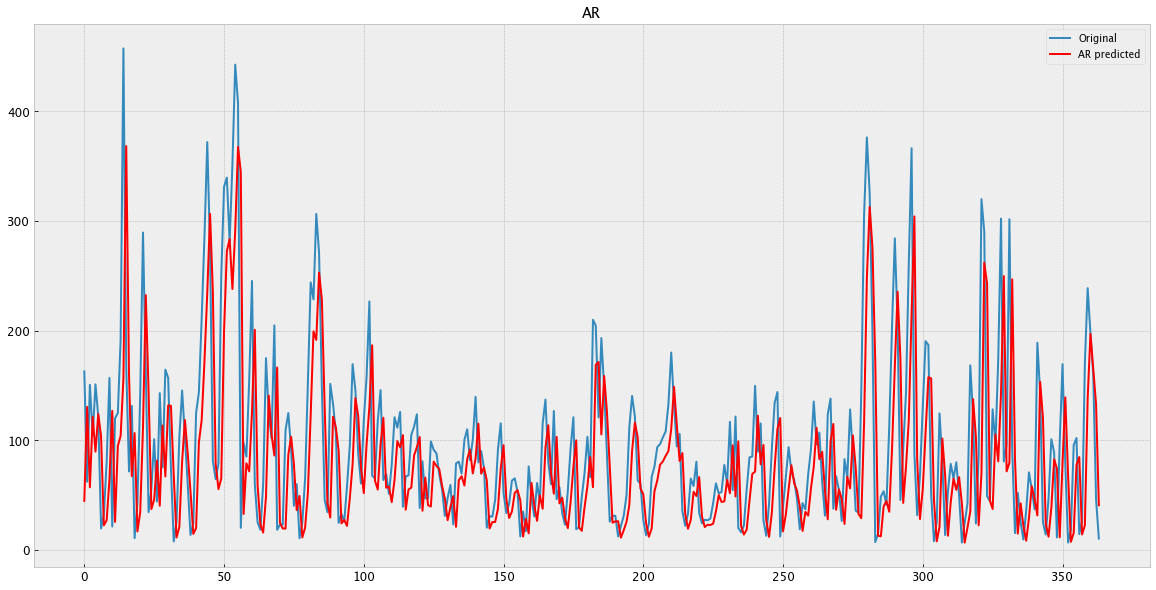

In [129]:
plt.figure(figsize = (20,10))
plt.plot(df_test.pollution.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.title('AR')
plt.legend()
plt.savefig("results/Autoregression.png")

##### Autoregressive Integrated Moving Average (ARIMA)


In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

- Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

- Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

- Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


In [62]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution))):
    temp_train = air_pollution[:len(df_training)+t]
    model_ARIMA = ARIMA(temp_train.pollution, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)

print(model_fit.summary())

100%|██████████| 364/364 [00:01<00:00, 248.61it/s]

                               AR Model Results                               
Dep. Variable:                      p  -                  o                  l
Model:                         AR(25)   Log Likelihood               -9786.057
Method:                          cmle   S.D. of innovations             62.294
Date:                Mon, 01 Feb 2021   AIC                              8.294
Time:                        06:46:25   BIC                              8.378
Sample:                             0   HQIC                             8.325
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            39.3893      5.451      7.226      0.000      28.706      50.073
L1.pollution      0.6612      0.024     27.566      0.000       0.614       0.708
L2.pollution     -0.2029      0.029     

In [81]:
#Istantiate
mod100 = ARIMA(air_pollution.pollution[1:], order = (1, 0, 0))

mod100_fit = mod100.fit(disp = 0)

print(mod100_fit.summary())

                              ARMA Model Results                              
Dep. Variable:              pollution   No. Observations:                 1788
Model:                     ARMA(1, 0)   Log Likelihood               -9967.665
Method:                       css-mle   S.D. of innovations             63.797
Date:                Mon, 01 Feb 2021   AIC                          19941.330
Time:                        07:01:36   BIC                          19957.796
Sample:                             0   HQIC                         19947.410
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              95.8049      3.416     28.044      0.000      89.109     102.501
ar.L1.pollution     0.5587      0.020     28.490      0.000       0.520       0.597
                                

In [91]:
mod420 = ARIMA(air_pollution.pollution[1:], order = (4,2,0))

mod420 = mod420.fit(disp = 0)

print(mod420.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.pollution   No. Observations:                 1786
Model:                 ARIMA(4, 2, 0)   Log Likelihood              -10381.075
Method:                       css-mle   S.D. of innovations             80.899
Date:                Mon, 01 Feb 2021   AIC                          20774.150
Time:                        07:22:30   BIC                          20807.077
Sample:                             2   HQIC                         20786.309
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0277      0.572     -0.048      0.961      -1.150       1.094
ar.L1.D2.pollution    -0.8012      0.023    -35.443      0.000      -0.846      -0.757
ar.L2.D2.pollution  

In [110]:
X = air_pollution.index
y = air_pollution['pollution']

train = air_pollution.loc[:'2010-01-02']
test = air_pollution.loc['2010-01-02':]

X_train, X_test = train.index, test.index
y_train, y_test = train['pollution'], test['pollution']

In [118]:
mod420 = ARIMA(y_train[2:], order=(4,2,0)) # p,d,q
mod420_fit = mod420.fit()

pred420 = mod420_fit.predict(start = '2010-01-02', end = '2014-12-31', dynamic = False)

In [ ]:
def RMSE(pred):
    return np.sqrt((pred-y_test) ** 2).mean()
print('RMSE SCORE IS:', RMSE_reg(pred420))

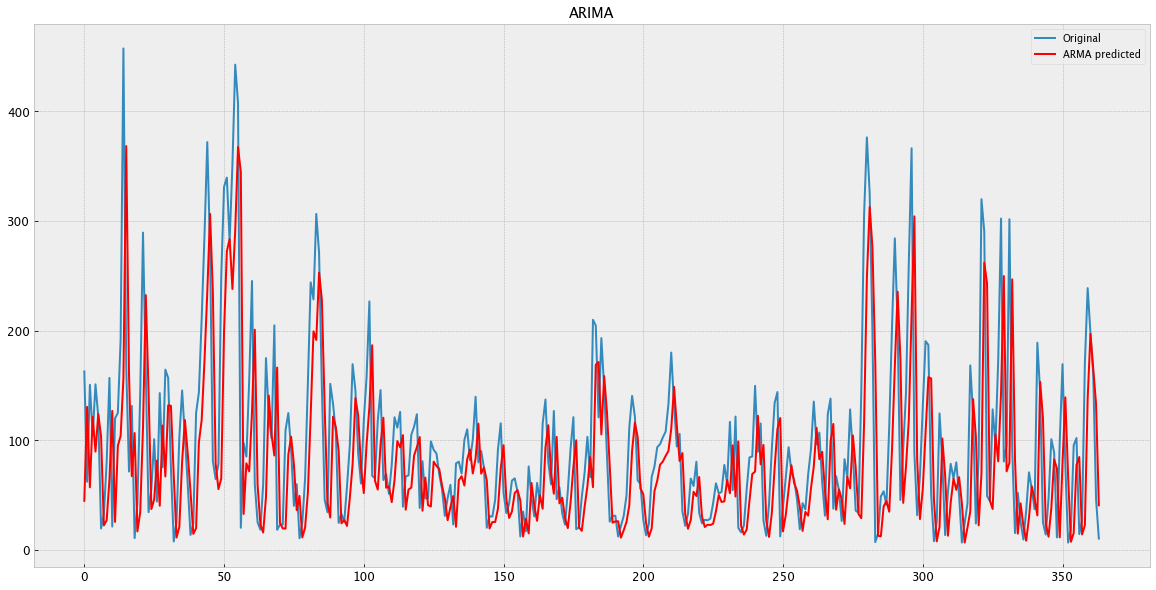

In [128]:
plt.figure(figsize = (20,10))
plt.plot(df_test.pollution.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
plt.title('ARIMA')
plt.legend()
plt.savefig("results/ARIMA.png")

##### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Trend Elements:
There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

Seasonal Elements:
There are four seasonal elements that are not part of ARIMA that must be configured; they are:
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

In [119]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)

100%|██████████| 364/364 [00:14<00:00, 25.57it/s]


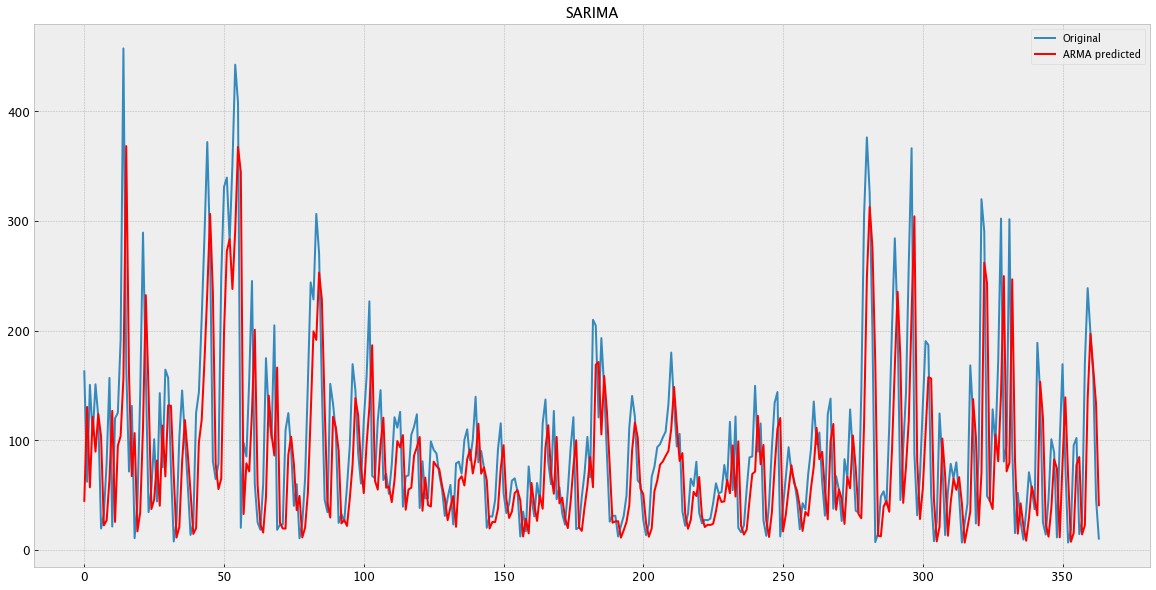

In [130]:
plt.figure(figsize = (20,10))
plt.plot(df_test.pollution.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
plt.title('SARIMA')
plt.legend()
plt.savefig('results/SARIMA.png')

##### Auto-SARIMA

In [121]:
#building the model
autoModel = pm.auto_arima(df_training.pollution, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.pollution)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=15845.849, Time=2.09 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16390.667, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=15875.354, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=15899.419, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=17742.116, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=15847.151, Time=0.46 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=15847.154, Time=0.56 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=15847.590, Time=2.77 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=15847.368, Time=2.70 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=15845.168, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=15843.993, Time=0.16 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=15845.989, Time=0.33 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=15845.951, Time=0.28 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=15847.092, Time=0.77 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [122]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)

100%|██████████| 364/364 [00:35<00:00, 10.40it/s]


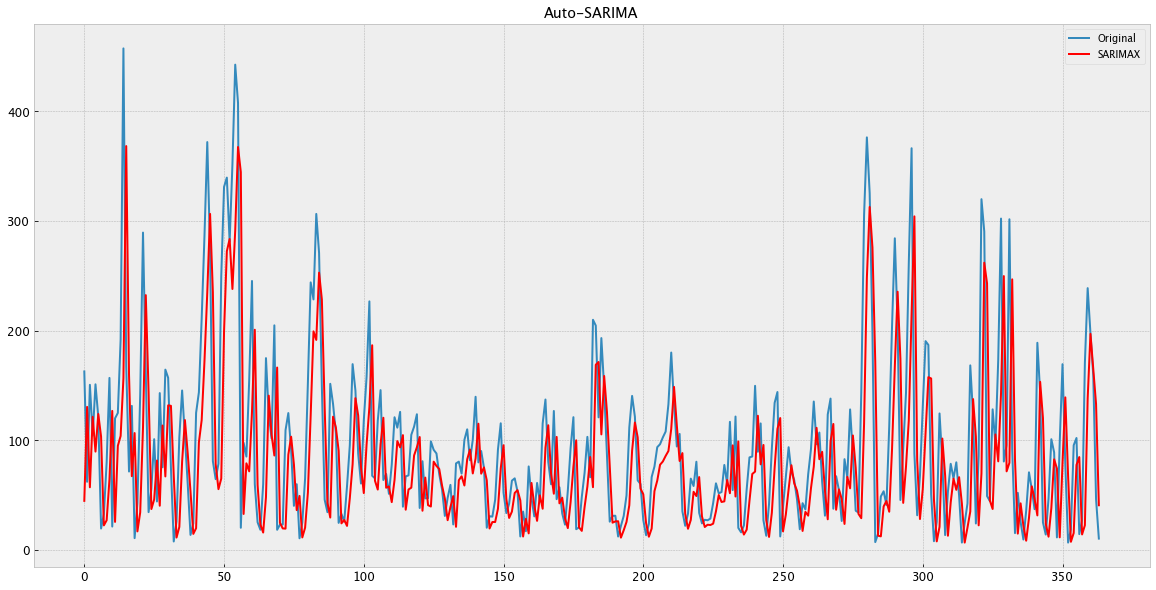

In [33]:
plt.figure(figsize = (20,10))
plt.plot(df_test.pollution.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.title('Auto-SARIMA')
plt.legend()

##### Prophet

Prophet is a model released by 
<a href="https://github.com/facebook/prophet">Facebook</a>. Is essentially a curve fitting approach,it uses generalized additive models instead of a state-space representation to describe each component.

In [34]:
prophet_training = df_training.rename(columns={'pollution': 'y'}) 
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'pollution': 'y'})   
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [35]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    holidays_prior_scale=20, 
    daily_seasonality=False, 
    weekly_seasonality=False, 
    yearly_seasonality=False
    ).add_seasonality(
        name='monthly',
        period=30,
        fourier_order=55
    ).add_seasonality(
        name='daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name='weekly',
        period=7,
        fourier_order=25
    ).add_seasonality(
        name='yearly',
        period=365,
        fourier_order=20
    ).add_seasonality(
        name='quarterly',
        period=365/4,
        fourier_order=55
    ).add_country_holidays(country_name='China')

In [36]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)

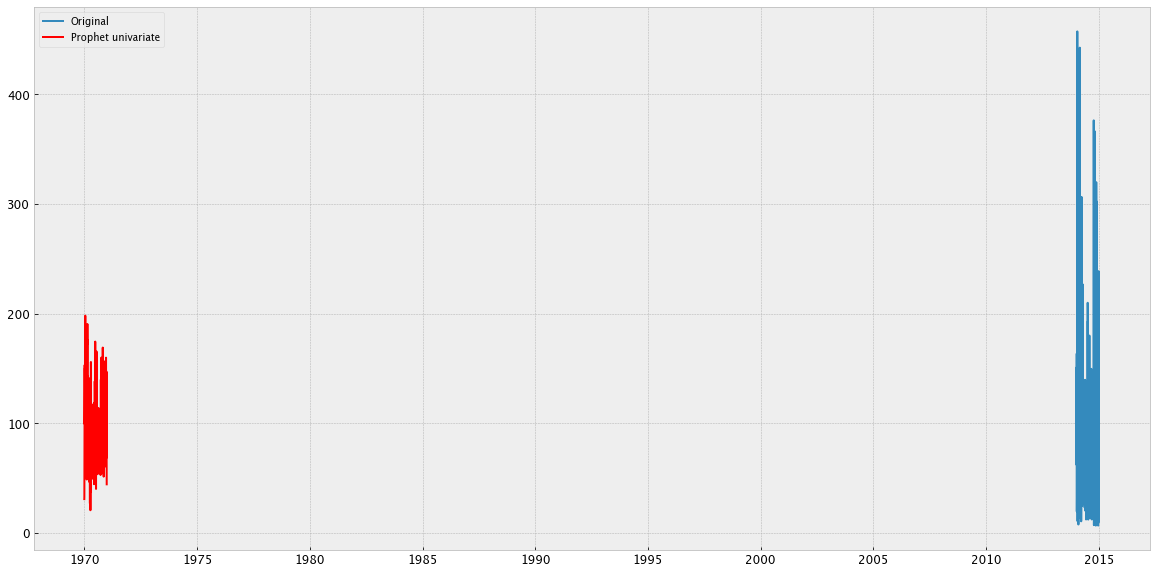

In [37]:
plt.figure(figsize = (20,10))
plt.plot(df_test.pollution, label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet univariate')
plt.legend()

Something went horribly wrong here, but I will include it in the notebook becuase I thought it was a cool attempt.

### Adding Features

In [38]:
def create_time_features(df,target=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [39]:
X_train_df, y_train = create_time_features(df_training, target='pollution')
X_test_df, y_test = create_time_features(df_test, target='pollution')
scaler = StandardScaler() 
scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

<ipython-input-38-7bd963f383ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-38-7bd963f383ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-38-7bd963f383ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

#### Linear Models

XG BOOST

In [40]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False)
yhat = reg.predict(X_test)

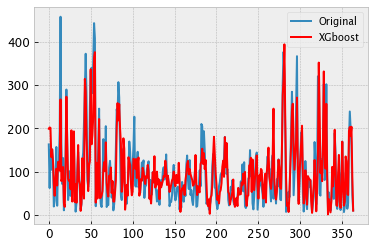

In [41]:
plt.plot(df_test.pollution.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
plt.legend()

###### Deep AR

In [42]:
features = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'pollution_yesterday', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler() 
scaler.fit(X_train)
df_training[features] = scaler.transform(df_training[features])  
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.pollution,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.pollution,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

<ipython-input-42-6caf2848c852>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_training[features] = scaler.transform(df_training[features])
/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-42-6caf2848c852>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [43]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1
                            , context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)





forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 25884
100%|██████████| 50/50 [00:02<00:00, 16.93it/s, epoch=1/5, avg_epoch_loss=5.71]
INFO:gluonts.trainer:Epoch[0] Elapsed time 2.955 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=5.712713
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 19.94it/s, epoch=2/5, avg_epoch_loss=5.54]
INFO:gluonts.trainer:Epoch[1] Elapsed time 2.508 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=5.543170
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 20.41it/s, epoch=3/5, avg_epoch_loss=5.46]
INFO:gluonts.trainer:Epoch[2] Elapsed time 2.451 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=5.459320
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 20.15it/s, epoch=4/5, avg_epoch_loss=5.39]
INFO:gluonts.trainer:Epoch[3] Elapsed time 2.482 seconds
INFO:gluo

#### Hyperparemter optimization

Bayesian processes - Xgboost

In [125]:
def rms(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3,15),
    'min_samples_leaf': (1,4),
    'min_samples_split': (2,10),
}
 
def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)
    
    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))
 
optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [127]:
#optimizer.maximize(
#    init_points=3,
#    n_iter=20,
#    acq='ei'
#)